### Globals

In [139]:
import numpy as np

x_data = [43.50, 41.50, 43.00, 41.82, 44.55, 42.86, 41.77, 43.22, 41.63, 44.02]
x_bar = np.mean(x_data)
v0 = 20.5
g = 9.81
sigma = 1.1
n = len(x_data)

In [142]:
def theta_hat(both_roots=False):
    const = v0**2/g
    if x_bar > const:
        print("Warning: x_bar > v0^2/g")
        return np.pi/4
    elif both_roots:
        return 0.5*np.arcsin(x_bar*g/(v0**2)), np.pi/2 - 0.5*np.arcsin(x_bar*g/(v0**2))
    else:
        return 0.5*np.arcsin(x_bar*g/(v0**2))
print(f" x_bar larger tham v0^2/g: {x_bar > v0**2/g}")

 x_bar larger tham v0^2/g: False


### e)

In [143]:
from scipy.stats import norm

mu_constant = v0**2 / g

def log_likelihood(theta):
    mu = mu_constant * np.sin(2 * theta)
    return np.sum(norm.logpdf(x_data, loc=mu, scale=sigma))

def metropolis_hastings(S, start = 0, end= np.pi/2, degen=False):
    theta = np.zeros(S)
    theta_0 = np.pi / 4 + 0.05
    prior_samples = np.random.uniform(start, end, size=S)
    if degen:
        i = np.random.uniform(0, 1, size=S) < 0.5
        prior_samples[i] = theta_0 
        
    theta[0] = prior_samples[0]
    log_likelihood_current = log_likelihood(theta[0])

    for s in range(1, S):
        theta_prime = prior_samples[s]
        log_likelihood_prime = log_likelihood(theta_prime)
   
        alpha = np.exp(log_likelihood_prime - log_likelihood_current)
        u = np.random.uniform(0, 1)
        
        if u <= alpha:
            # Accept
            theta[s] = theta_prime
            log_likelihood_current = log_likelihood_prime
        else:
            # Reject, use previous value
            theta[s] = theta[s - 1]
    
    return theta





In [144]:
S = 10**5 
samples = metropolis_hastings(S)

### f)

#### True posterior using numerical integration

In [145]:
#true posterior
from scipy.integrate import quad
likelihood = lambda theta: np.exp(log_likelihood(theta)) #likelihood for the data
norm_constant = quad(likelihood, 0, np.pi / 2)[0] #normalizing constant for the data
posterior_pdf = lambda theta: likelihood(theta) / norm_constant 


### Laplace approx

In [147]:
def A(theta):
    const = v0**2/g
    if x_bar > const:
        return -sigma**2 * g**2 / (4 * v0**4 * n *(1-x_bar*g**2))
    else:
        return sigma**2 *g**2/(4*v0**4 *n * np.cos(2*theta)**2)
    

def laplace_approximation_pdf(x):
    mu = theta_hat()
    return norm.pdf(x, loc=mu, scale=np.sqrt(A(theta_hat())))

### Plotting MCMC samples, true posterior and Laplace approximation

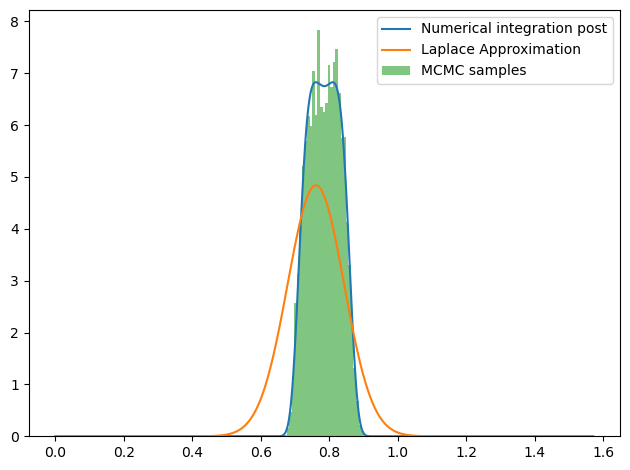

In [151]:

import matplotlib.pyplot as plt

theta_range = np.linspace(0, np.pi / 2, 1000)

true_posterior_color = '#1f77b4'  
laplace_color = '#ff7f0e'         
mcmc_color = '#2ca02c'            

plt.plot(theta_range, [posterior_pdf(theta) for theta in theta_range], color=true_posterior_color, label='Numerical integration post')
plt.plot(theta_range, laplace_approximation_pdf(theta_range), color=laplace_color, label='Laplace Approximation')
plt.hist(samples, bins=50, density=True, color=mcmc_color, alpha=0.6, label='MCMC samples')
plt.tight_layout()
plt.legend()



### g)

In [162]:
theta_0 = np.pi / 4 + 0.05

### numerical integration

In [163]:
def p_H0_num_integration(start, end):
    #integrate likelihood from start to end
    prior = 1/(end - start)
    lik_theta0 = likelihood(theta_0)
    lik_theta = quad(likelihood, start, end)[0]*prior
    return lik_theta0/(lik_theta + lik_theta0)

In [164]:
mcmc_samples = metropolis_hastings(S, degen=True)
p_H0 = np.mean(mcmc_samples == theta_0)
p_H0_num = p_H0_num_integration(0, np.pi/2)
print(f"probability of theta = theta_0 using MCMC: {p_H0}")
print(f"probability of H0 using numerical integration: {p_H0_num}")

probability of theta = theta_0 using MCMC: 0.90434
probability of H0 using numerical integration: 0.905827758875099


### h)

In [166]:
mcmc_samples = metropolis_hastings(S, start=theta_0-0.1, end=theta_0+0.1, degen=True)
p_H0 = np.mean(mcmc_samples == theta_0)
p_H0_num = p_H0_num_integration(theta_0 - 0.1, theta_0 + 0.1)
print(f"probability of theta = theta_0 using MCMC: {p_H0}")
print(f"probability of H0 using numerical integration: {p_H0_num}")
plt.show()

probability of theta = theta_0 using MCMC: 0.59087
probability of H0 using numerical integration: 0.5945531354407728
